In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_curve, roc_auc_score, 
                             f1_score, precision_score, recall_score)

from sklearn.svm import SVC
from xgboost import XGBClassifier
import mlflow
import mlflow.xgboost

import tensorflow as tf
import numpy as np
import random

In [2]:
data_path = "Data/heart.csv"
df = pd.read_csv(data_path)

# Change col name
df.columns = ['Age', 'Sex', 'ChestPainType', 'RestingBloodPressure', 'Cholesterol', 'FastingBloodSugar', 
              'RestingECG', 'MaxHeartRate', 'ExerciseInducedAngina', 'STDepression', 'STSlope', 
              'NumMajorVessels', 'Thalassemia', 'HeartAttackRisk']

In [3]:
start = len(df)

df = df[df['NumMajorVessels'] < 4]  # Drop the wrong NumMajorVessels values
df = df[df['Thalassemia'] > 0]  # Drop the wrong Thalassemia values

df = df.reset_index(drop=True)  # Reset the index and drop the old one

print(f'The length of the data now is {len(df)} instead of {start}')

The length of the data now is 296 instead of 303


In [4]:
df = df.astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    296 non-null    float64
 1   Sex                    296 non-null    float64
 2   ChestPainType          296 non-null    float64
 3   RestingBloodPressure   296 non-null    float64
 4   Cholesterol            296 non-null    float64
 5   FastingBloodSugar      296 non-null    float64
 6   RestingECG             296 non-null    float64
 7   MaxHeartRate           296 non-null    float64
 8   ExerciseInducedAngina  296 non-null    float64
 9   STDepression           296 non-null    float64
 10  STSlope                296 non-null    float64
 11  NumMajorVessels        296 non-null    float64
 12  Thalassemia            296 non-null    float64
 13  HeartAttackRisk        296 non-null    float64
dtypes: float64(14)
memory usage: 32.5 KB


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,296.0,54.523649,9.059471,29.0,48.0,56.0,61.00,77.0
Sex,296.0,0.679054,0.467631,0.0,0.0,1.0,1.00,1.0
ChestPainType,296.0,0.959459,1.034184,0.0,0.0,1.0,2.00,3.0
RestingBloodPressure,296.0,131.604730,17.726620,94.0,120.0,130.0,140.00,200.0
Cholesterol,296.0,247.155405,51.977011,126.0,211.0,242.5,275.25,564.0
FastingBloodSugar,296.0,0.145270,0.352970,0.0,0.0,0.0,0.00,1.0
RestingECG,296.0,0.523649,0.526692,0.0,0.0,1.0,1.00,2.0
MaxHeartRate,296.0,149.560811,22.970792,71.0,133.0,152.5,166.00,202.0
ExerciseInducedAngina,296.0,0.327703,0.470171,0.0,0.0,0.0,1.00,1.0
STDepression,296.0,1.059122,1.166474,0.0,0.0,0.8,1.65,6.2


In [6]:
df.head()

,Age,Sex,ChestPainType,RestingBloodPressure,Cholesterol,FastingBloodSugar,RestingECG,MaxHeartRate,ExerciseInducedAngina,STDepression,STSlope,NumMajorVessels,Thalassemia,HeartAttackRisk
0,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0


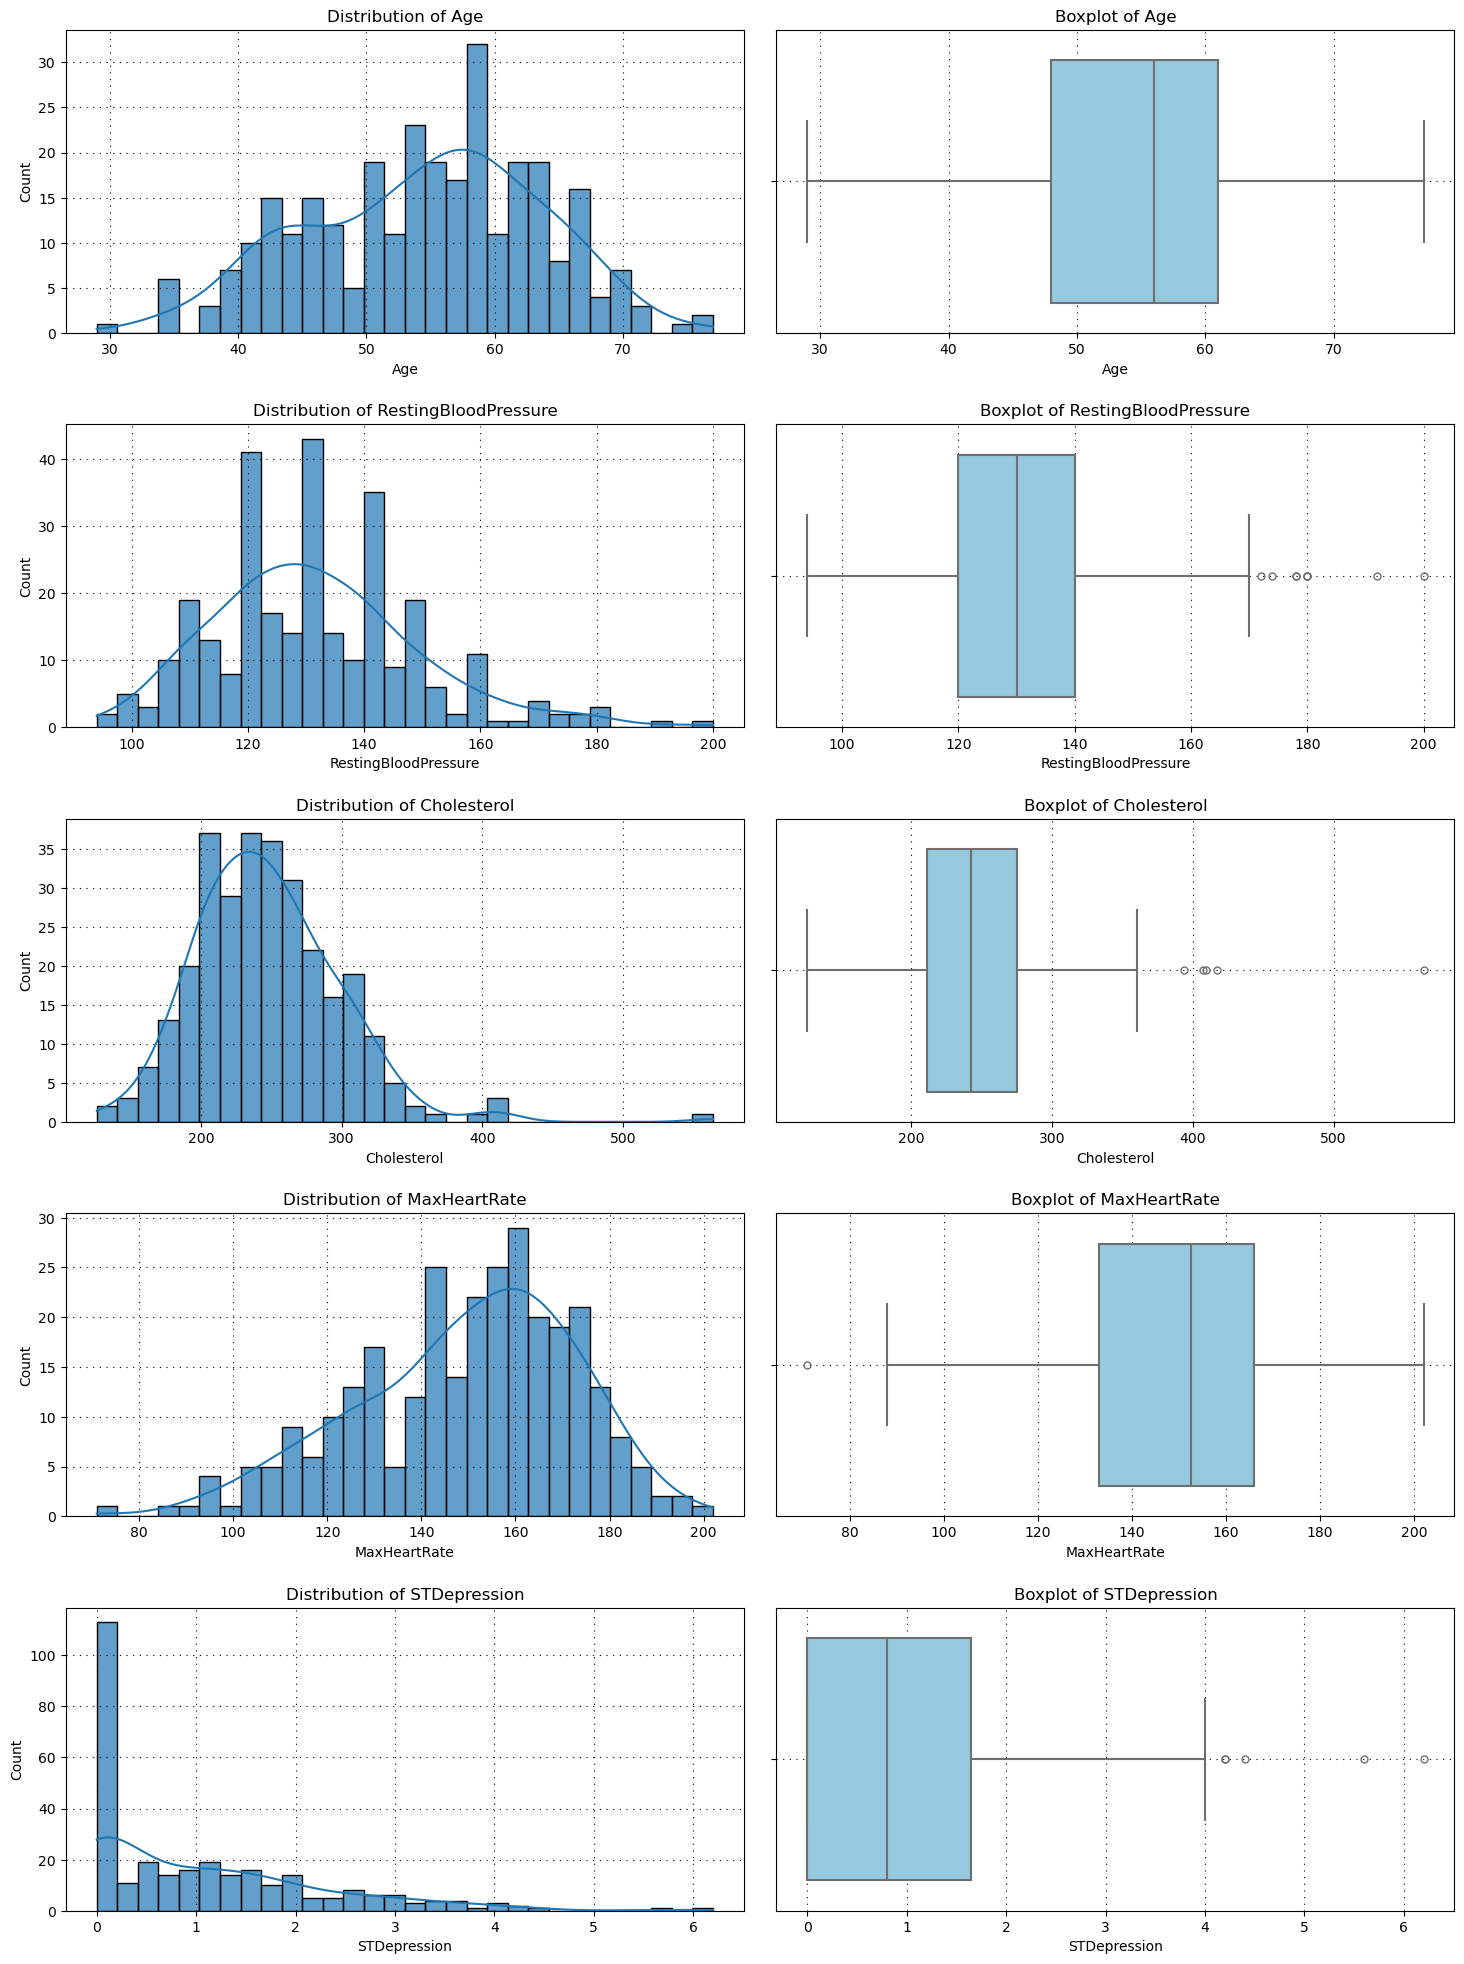

In [7]:
# Lista kolumn numerycznych
numerical_columns = ['Age', 'RestingBloodPressure', 'Cholesterol', 'MaxHeartRate', 'STDepression']

# Ustawienie figury Matplotlib
plt.figure(figsize=(15, 20))

# Pętla do generowania wykresów
for i, col in enumerate(numerical_columns):
    # Histogram
    plt.subplot(len(numerical_columns), 2, 2 * i + 1)
    sns.histplot(df[col], kde=True, bins=30, alpha=0.7)  # Dodanie przezroczystości
    plt.grid(color='#000000', linestyle=':', zorder=0, dashes=(1,5))
    plt.title(f'Distribution of {col}')

    # Boxplot
    plt.subplot(len(numerical_columns), 2, 2 * i + 2)
    sns.boxplot(x=df[col], color="skyblue", fliersize=5, linewidth=1.5)  # Możliwość dodania koloru z przezroczystością
    plt.grid(color='#000000', linestyle=':', zorder=0, dashes=(1,5))
    plt.title(f'Boxplot of {col}')

# Dostosowanie przestrzeni między wykresami
plt.tight_layout(pad=2.0)
plt.savefig("EDA/Histplots_with_Boxplots", dpi=1000)
plt.show()
plt.close()

In [8]:
from scipy.stats import shapiro, skew, kurtosis

results = []

for col in numerical_columns:
    stat, p_value = shapiro(df[col])
    skewness = skew(df[col])
    kurt = kurtosis(df[col])
    
    results.append({
        'Column': col,
        'Shapiro-Wilk Statistic': stat,
        'p-value': p_value,
        'Skewness': skewness,
        'Kurtosis': kurt
    })

results_df = pd.DataFrame(results)
results_df

,Column,Shapiro-Wilk Statistic,p-value,Skewness,Kurtosis
0,Age,0.986155,6.044837e-03,-0.213325,-0.537590
1,RestingBloodPressure,0.965949,1.912894e-06,0.707152,0.822685
2,Cholesterol,0.947630,8.985581e-09,1.124171,4.397804
3,MaxHeartRate,0.976990,1.072688e-04,-0.528973,-0.079860
4,STDepression,0.849199,2.500522e-16,1.237241,1.457817


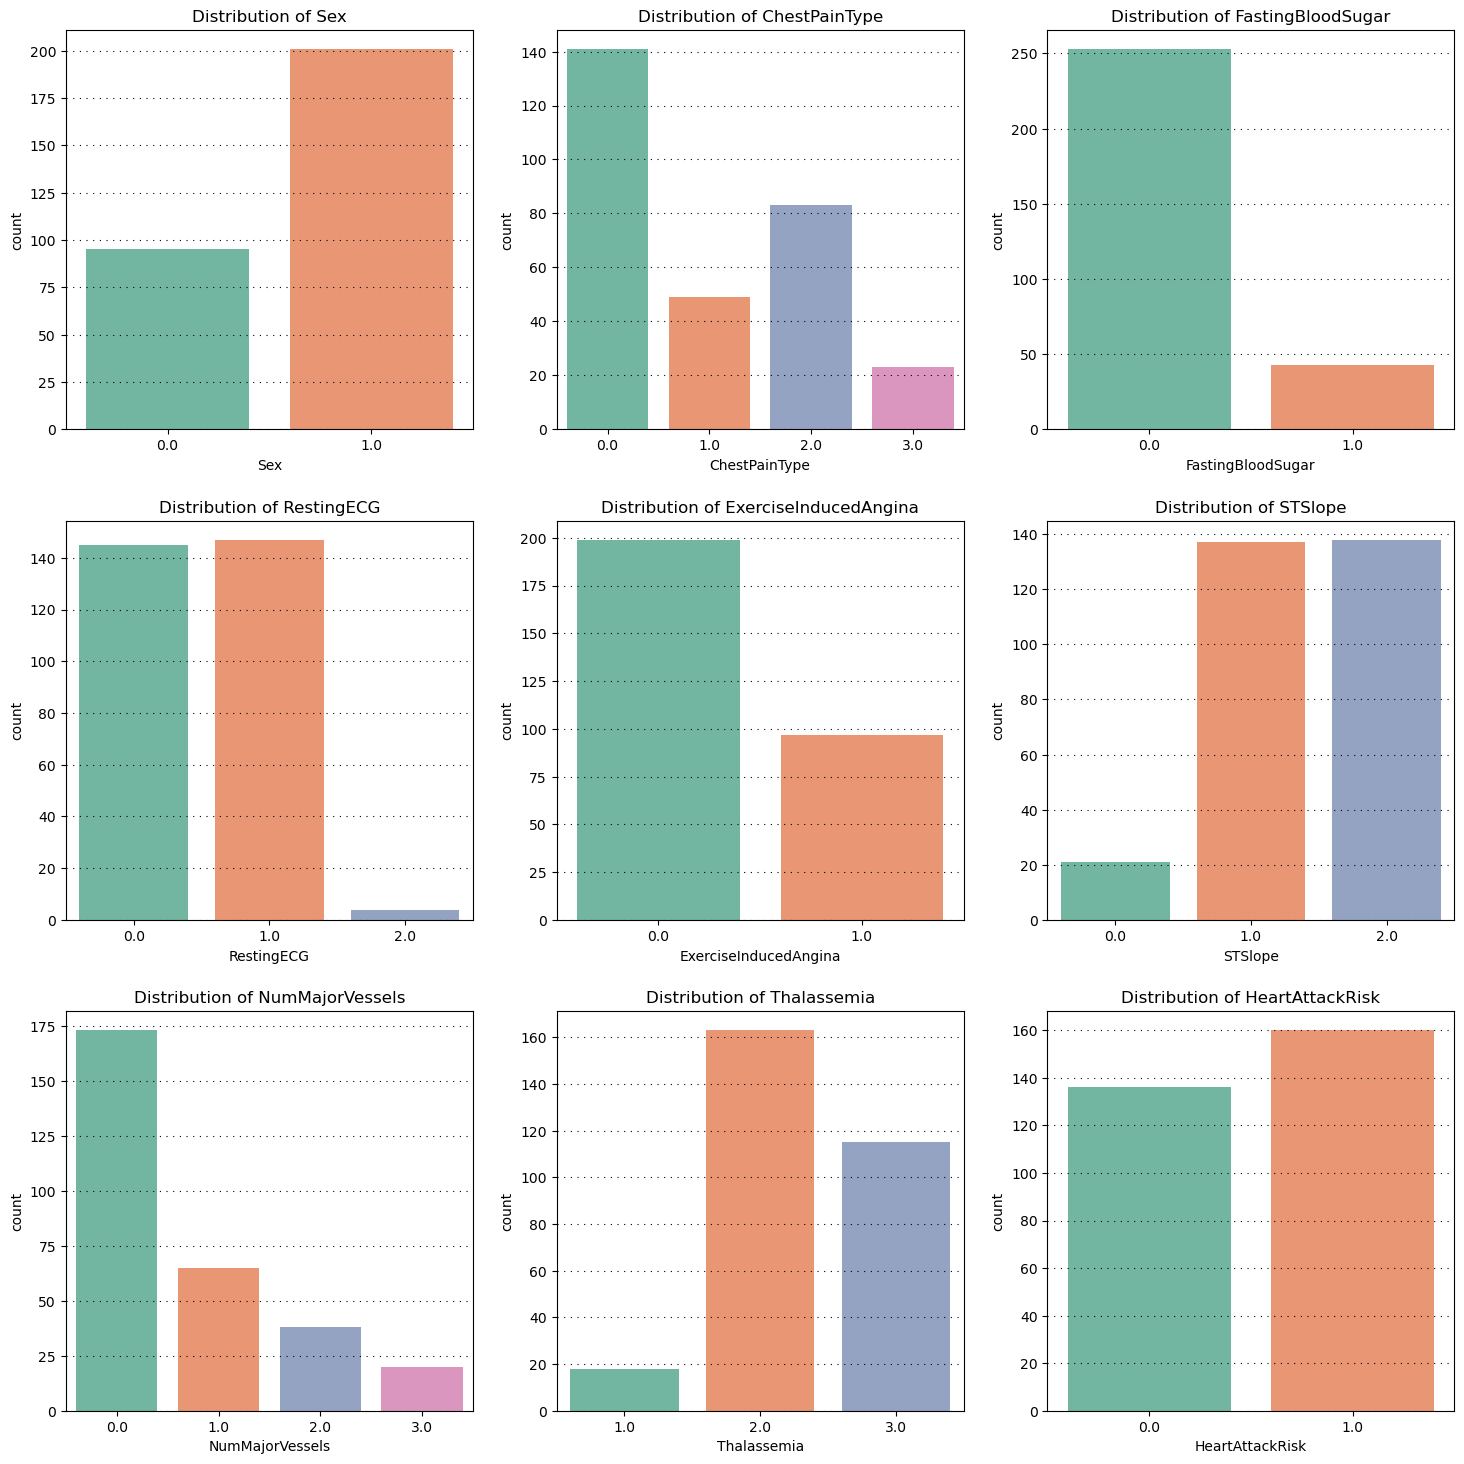

In [9]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 15))

categorical_columns = ['Sex', 'ChestPainType', 'FastingBloodSugar', 'RestingECG', 
                       'ExerciseInducedAngina', 'STSlope', 'NumMajorVessels', 'Thalassemia', 'HeartAttackRisk']

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=df[col], hue=df[col], palette='Set2', legend=False)
    plt.grid(color='#000000', linestyle=':', axis='y', zorder=0, dashes=(1,5))
    plt.title(f'Distribution of {col}')

plt.tight_layout(pad=2.0)
plt.savefig("EDA/Countplots", dpi=1000)
plt.show()
plt.close()

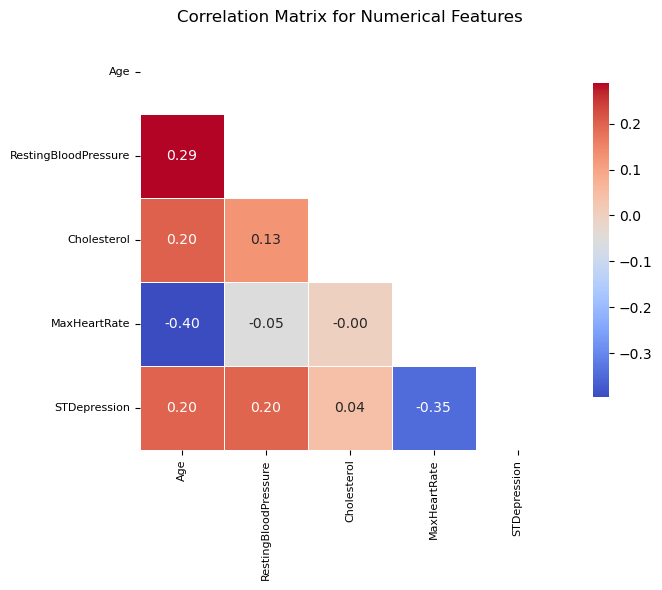

In [10]:
# Compute the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with the mask
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .75}, fmt='.2f')

# Make the titles and labels more readable
plt.title('Correlation Matrix for Numerical Features', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8, rotation=0)

plt.tight_layout()
plt.savefig("EDA/CorrMatrix", dpi=300)
plt.show()
plt.close()

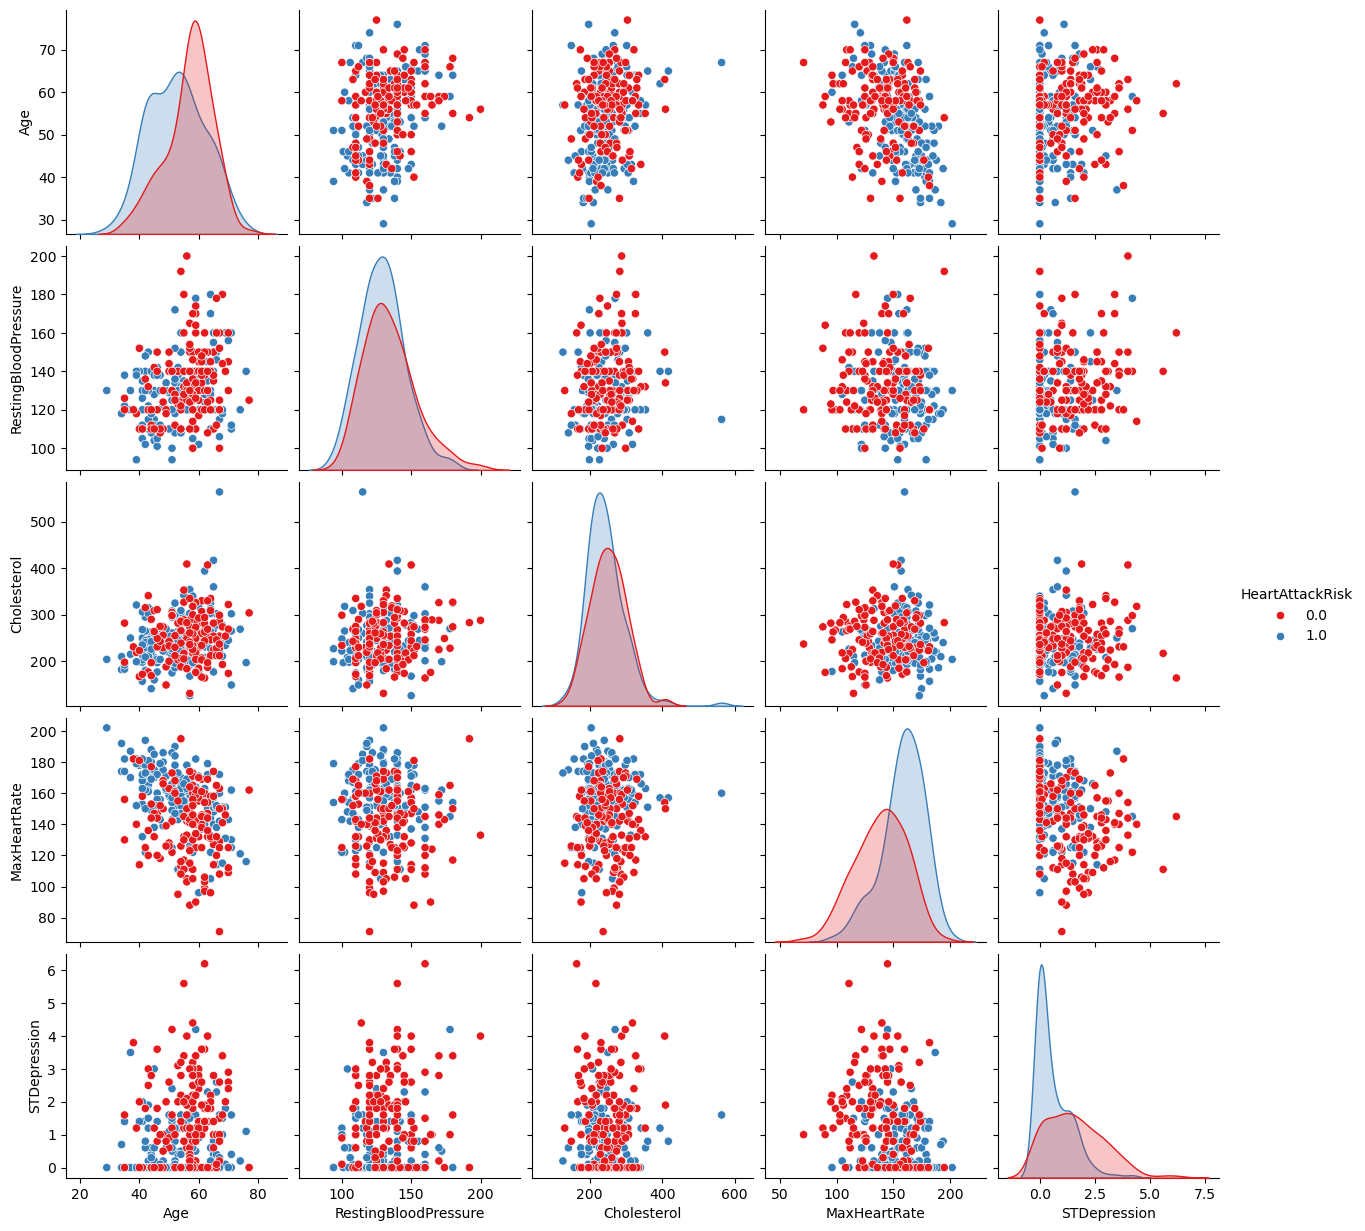

In [11]:
sns.pairplot(df, hue='HeartAttackRisk', vars=numerical_columns, palette='Set1')
plt.savefig("EDA/Pairplots", dpi=1000)
plt.show()
plt.close()

In [12]:
from sklearn.model_selection import train_test_split

X = df.drop(['HeartAttackRisk'], axis=1) 
y = df['HeartAttackRisk']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [13]:
# print('Shape for training data', X_train.shape, y_train.shape)
# print('Shape for testing data', X_test.shape, y_test.shape)

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
# X_test = scaler.transform(X_test)

In [15]:
# Initialize a DataFrame to store metrics for different models
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

def evaluate_model_with_cv(model, X, y, params=None, cv=5):
    """
    Function to perform cross-validation with a specified model, display the confusion matrix, 
    plot the ROC AUC curve, and calculate the model's accuracy. Optionally performs hyperparameter 
    tuning using GridSearchCV. Also, collects important metrics for further comparison.
    
    :param model: The classification model (e.g., LogisticRegression, RandomForestClassifier).
    :param X: Feature dataset.
    :param y: Target labels.
    :param params: Parameter grid for GridSearchCV (optional).
    :param cv: Number of cross-validation folds (default is 5).
    :return: The best model and its accuracy.
    """
    
    # If parameter grid is provided, perform GridSearchCV
    if params:
        grid_search = GridSearchCV(model, param_grid=params, cv=cv, scoring='accuracy', verbose=1)
        grid_search.fit(X, y)
        model = grid_search.best_estimator_  # Update model to the best found by GridSearchCV
        print(f"Best Parameters: {grid_search.best_params_}")
    
    # Predict values using cross-validation
    y_pred = cross_val_predict(model, X, y, cv=cv, method='predict')
    y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]

    # Compute the confusion matrix
    conf = confusion_matrix(y, y_pred)

    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the confusion matrix on the first subplot
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - {cv}-Fold Cross-Validation')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y, y_pred_proba)

    # Plot the ROC AUC curve on the second subplot
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    axes[1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], linestyle='--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC AUC Curve - {cv}-Fold Cross-Validation')
    axes[1].legend(loc='lower right')

    # Ensure the 'Results' directory exists
    os.makedirs('Results', exist_ok=True)

    # Save the figure to the 'Results' directory with a dynamic name based on the model
    model_name = model.__class__.__name__
    plot_path = os.path.join('Results', f'results_{model_name}.png')
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()
    
    # Calculate additional metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    # Append the metrics to the DataFrame
    metrics_df.loc[len(metrics_df)] = [model_name, accuracy, precision, recall, f1, roc_auc]
    
    return model, accuracy, metrics_df

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'C': 0.055, 'l1_ratio': 0.8, 'max_iter': 80, 'penalty': 'elasticnet', 'solver': 'saga'}


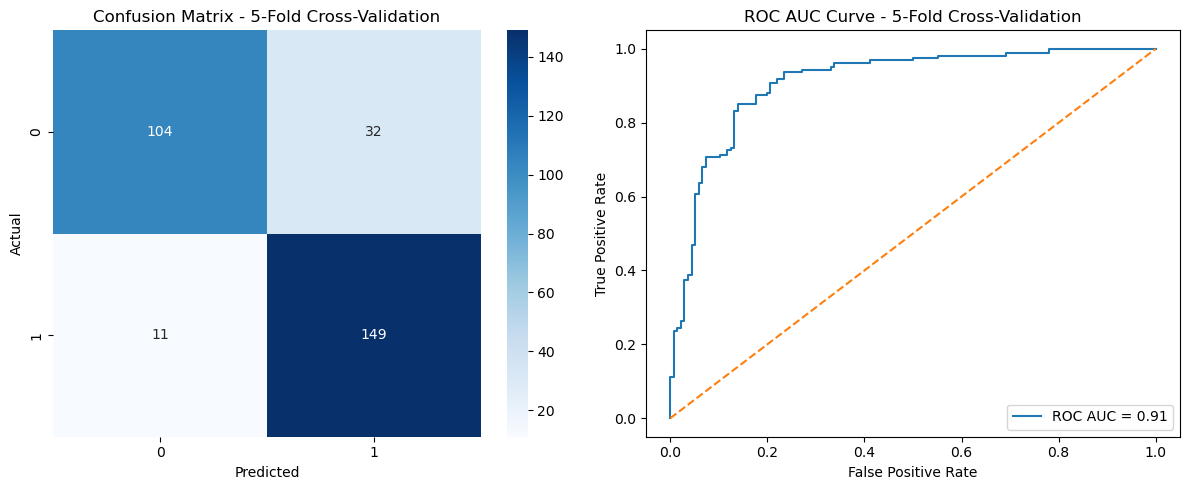

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegression,0.85473,0.823204,0.93125,0.8739,0.909651


In [16]:
model_LR = LogisticRegression(random_state=42)

params_LR = {
    'penalty': ['elasticnet'],
    'C': [0.045, 0.05, 0.055],
    'solver': ['saga'],
    'l1_ratio': [0.8, 0.825, 0.85],
    'max_iter': [80, 100, 120]}

best_model_LR, accuracy, metrics_df = evaluate_model_with_cv(model_LR, X, y, params=params_LR, cv=5)
metrics_df

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.75, 'gamma': 0, 'learning_rate': 0.025, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.7}


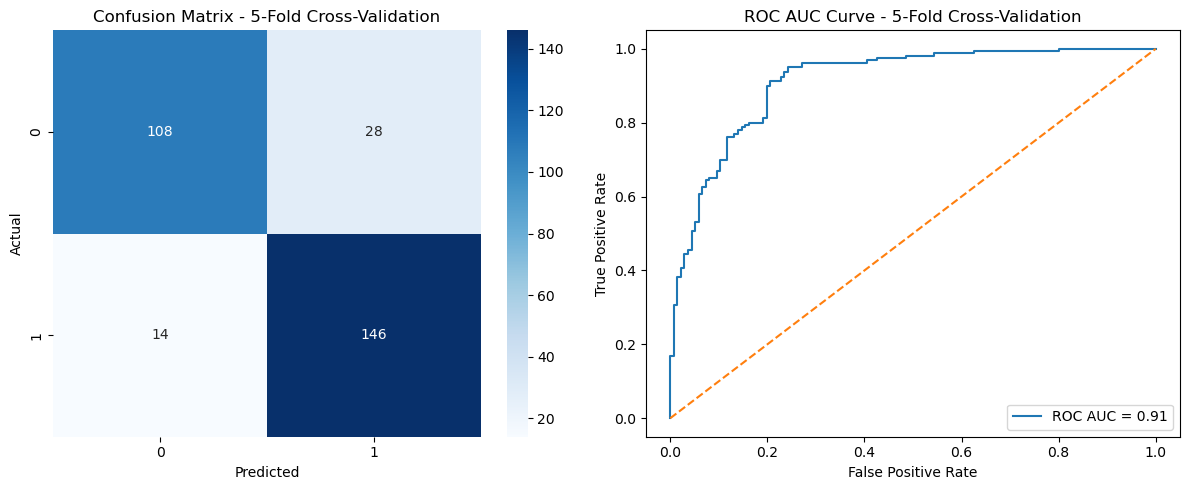

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegression,0.854730,0.823204,0.93125,0.873900,0.909651
1,XGBClassifier,0.858108,0.839080,0.91250,0.874251,0.911811


In [17]:
model_XGB = XGBClassifier(eval_metric='auc', random_state=42)

params_XGB = {
    'n_estimators': [80, 90, 100],
    'learning_rate': [0.015, 0.02, 0.025],
    'max_depth': [1, 2, 3],
    'subsample': [0.7, 0.75, 0.8],
    'colsample_bytree': [0.75, 0.8, 0.85],
    'gamma': [0, 0.01, 0.05],
}

best_model_XGB, accuracy, metrics_df = evaluate_model_with_cv(model_XGB, X, y, params=params_XGB, cv=5)
metrics_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 0.125, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


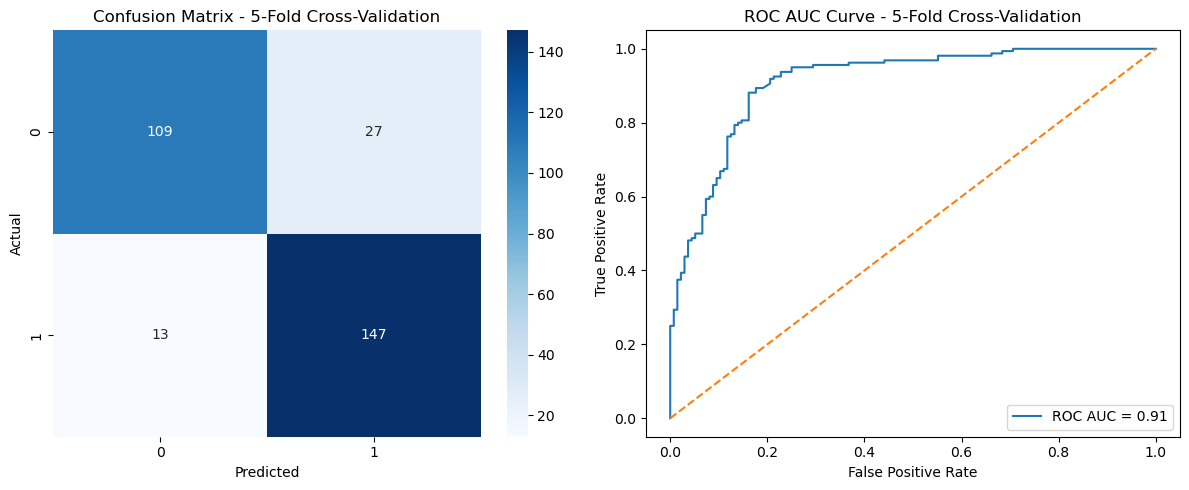

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegression,0.854730,0.823204,0.93125,0.873900,0.909651
1,XGBClassifier,0.858108,0.839080,0.91250,0.874251,0.911811
2,SVC,0.864865,0.844828,0.91875,0.880240,0.910570


In [18]:
model_SVC = SVC(probability=True, random_state=42)

params_SVC = {
    'C': [0.1, 0.115, 0.125, 0.135, 0.15],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto'], 
    'degree': [2],
    'class_weight': [None, 'balanced'],
}

best_model_SVC, accuracy, metrics_df = evaluate_model_with_cv(model_SVC, X, y, params=params_SVC, cv=5)
metrics_df

## Neural Network

Fold 1

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


D:\Programy\Anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 1 results - Accuracy: 0.9166666666666666, Precision: 0.9090909090909091, Recall: 0.9375, F1 Score: 0.9230769230769231, ROC AUC: 0.9720982142857143
Fold 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


D:\Programy\Anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 2 results - Accuracy: 0.9152542372881356, Precision: 0.9354838709677419, Recall: 0.90625, F1 Score: 0.9206349206349206, ROC AUC: 0.9791666666666667
Fold 3
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000106131A99E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


D:\Programy\Anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 3 results - Accuracy: 0.8135593220338984, Precision: 0.8181818181818182, Recall: 0.84375, F1 Score: 0.8307692307692308, ROC AUC: 0.9490740740740742
Fold 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


D:\Programy\Anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 4 results - Accuracy: 0.9491525423728814, Precision: 0.9393939393939394, Recall: 0.96875, F1 Score: 0.9538461538461539, ROC AUC: 0.9664351851851851
Fold 5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


D:\Programy\Anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 5 results - Accuracy: 0.8813559322033898, Precision: 0.8205128205128205, Recall: 1.0, F1 Score: 0.9014084507042254, ROC AUC: 0.9583333333333333


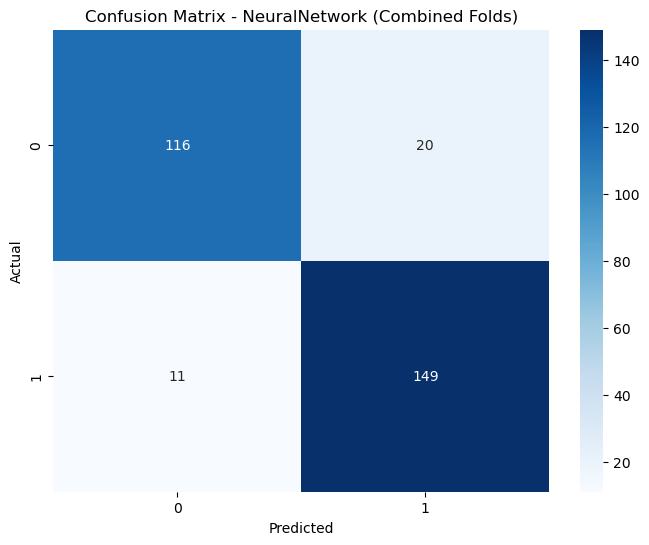

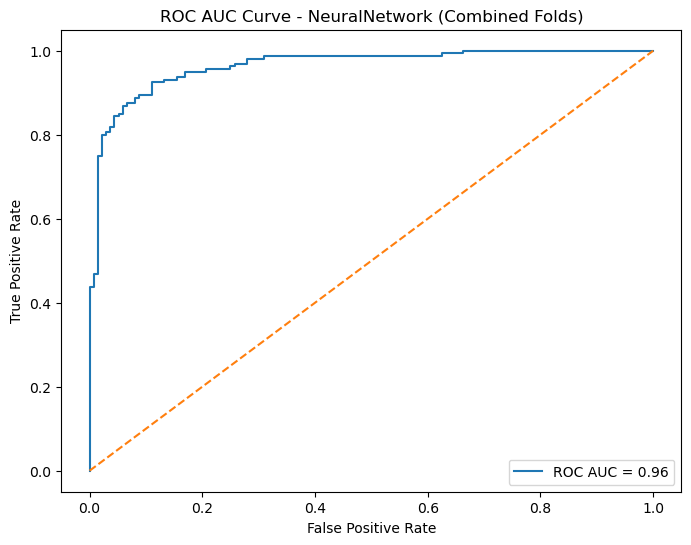

Best parameters per fold:
   num_layers  units_0  dropout_0  learning_rate  units_1  dropout_1  units_2  \
0           4      208        0.2       0.001144      120        0.4       40   
1           4      208        0.2       0.001144      120        0.4       40   
2           4      208        0.2       0.001144      120        0.4       40   
3           4      208        0.2       0.001144      120        0.4       40   
4           4      208        0.2       0.001144      120        0.4       40   

   dropout_2  units_3  dropout_3  
0        0.2      120        0.4  
1        0.2      120        0.4  
2        0.2      120        0.4  
3        0.2      120        0.4  
4        0.2      120        0.4  
Most common parameters across folds:
{'num_layers': 4, 'units_0': 208, 'dropout_0': 0.2, 'learning_rate': 0.001143658575772979, 'units_1': 120, 'dropout_1': 0.4, 'units_2': 40, 'dropout_2': 0.2, 'units_3': 120, 'dropout_3': 0.4}
Mean Results - Accuracy: 0.8951977401129945, Pre

In [19]:
import keras_tuner as kt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to build the model
def build_model(hp):
    model = Sequential()

    # Decide the number of hidden layers
    for i in range(hp.Int('num_layers', 1, 4)):  # Test between 1 to 3 hidden layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=8, max_value=256, step=8), activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the Adam optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Compile the model with tuned optimizer and learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,  # Increase the number of trials to accommodate more complex search space
    executions_per_trial=3,
    overwrite=True
)

# K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Track results
results = []
best_params_per_fold = []
all_y_true = []
all_y_pred = []
all_y_pred_proba = []

for fold_no, (train_index, val_index) in enumerate(kfold.split(X, y), 1):  # Use X and y directly
    print(f"Fold {fold_no}")
    
    # Split data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Search for the best model using the tuner
    tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=0)
    
    # Get the best model and its hyperparameters
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hp = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
    best_params_per_fold.append(best_hp)
    
    # Evaluate the model on the validation set
    y_pred_proba = best_model.predict(X_val).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Store results for later analysis
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)
    all_y_pred_proba.extend(y_pred_proba)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    print(f"Fold {fold_no} results - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, ROC AUC: {roc_auc}")
    
    results.append([accuracy, precision, recall, f1, roc_auc])

# Plot confusion matrix for all predictions
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - NeuralNetwork (Combined Folds)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Results/confusion_matrix_NeuralNetwork.png')
plt.show()

# Plot ROC AUC curve for all predictions
fpr, tpr, _ = roc_curve(all_y_true, all_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(all_y_true, all_y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC AUC Curve - NeuralNetwork (Combined Folds)')
plt.legend(loc='lower right')
plt.savefig('Results/roc_auc_NeuralNetwork.png')
plt.show()

# Summarize the best hyperparameters
params_df = pd.DataFrame(best_params_per_fold)
print("Best parameters per fold:")
print(params_df)

# Summarize the most common hyperparameters across folds
param_summary = {}
for column in params_df.columns:
    most_common = Counter(params_df[column]).most_common(1)[0][0]
    param_summary[column] = most_common

print("Most common parameters across folds:")
print(param_summary)

# Calculate the mean results and log to metrics_df
mean_results = np.mean(results, axis=0)
print(f"Mean Results - Accuracy: {mean_results[0]}, Precision: {mean_results[1]}, Recall: {mean_results[2]}, F1 Score: {mean_results[3]}, ROC AUC: {mean_results[4]}")

# Append the mean results to the existing metrics DataFrame
metrics_df.loc[len(metrics_df)] = ['NeuralNetwork', *mean_results]

# Save the updated metrics DataFrame to a CSV file
metrics_df.to_csv('Results/metrics_updated.csv', index=False)

print("Experiment completed.")

In [20]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegression,0.854730,0.823204,0.93125,0.873900,0.909651
1,XGBClassifier,0.858108,0.839080,0.91250,0.874251,0.911811
2,SVC,0.864865,0.844828,0.91875,0.880240,0.910570
3,NeuralNetwork,0.895198,0.884533,0.93125,0.905947,0.965021


In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Najlepsze parametry modelu na podstawie wcześniejszych wyników
best_params = {
    'num_layers': 3,
    'units_0': 104,
    'dropout_0': 0.2,
    'learning_rate': 0.0011,
    'units_1': 16,
    'dropout_1': 0.2,
    'units_2': 192,
    'dropout_2': 0.0
}

def build_best_model(params):
    model = Sequential()
    
    # Pierwsza warstwa
    model.add(Dense(units=params['units_0'], activation='relu'))
    model.add(Dropout(rate=params['dropout_0']))
    
    # Druga warstwa
    model.add(Dense(units=params['units_1'], activation='relu'))
    model.add(Dropout(rate=params['dropout_1']))
    
    # Trzecia warstwa
    model.add(Dense(units=params['units_2'], activation='relu'))
    model.add(Dropout(rate=params['dropout_2']))
    
    # Warstwa wyjściowa
    model.add(Dense(1, activation='sigmoid'))
    
    # Kompilacja modelu
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Utwórz model z najlepszymi parametrami
best_model = build_best_model(best_params)

Fold 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Fold 1 results - Accuracy: 0.9166666666666666, Precision: 0.9090909090909091, Recall: 0.9375, F1 Score: 0.9230769230769231, ROC AUC: 0.9709821428571429


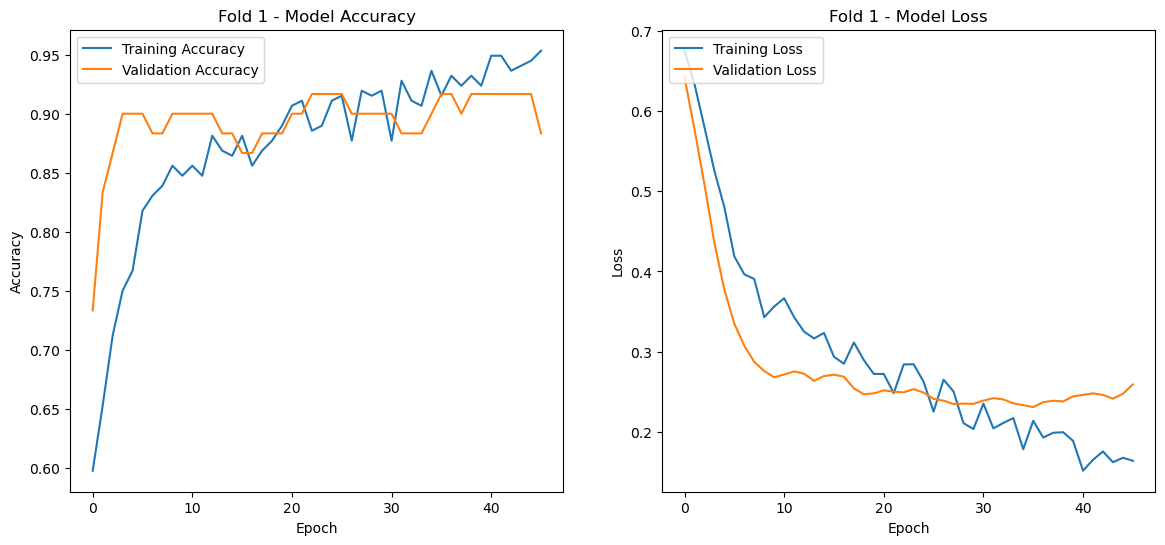

Fold 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 2 results - Accuracy: 0.9830508474576272, Precision: 0.9696969696969697, Recall: 1.0, F1 Score: 0.9846153846153847, ROC AUC: 1.0


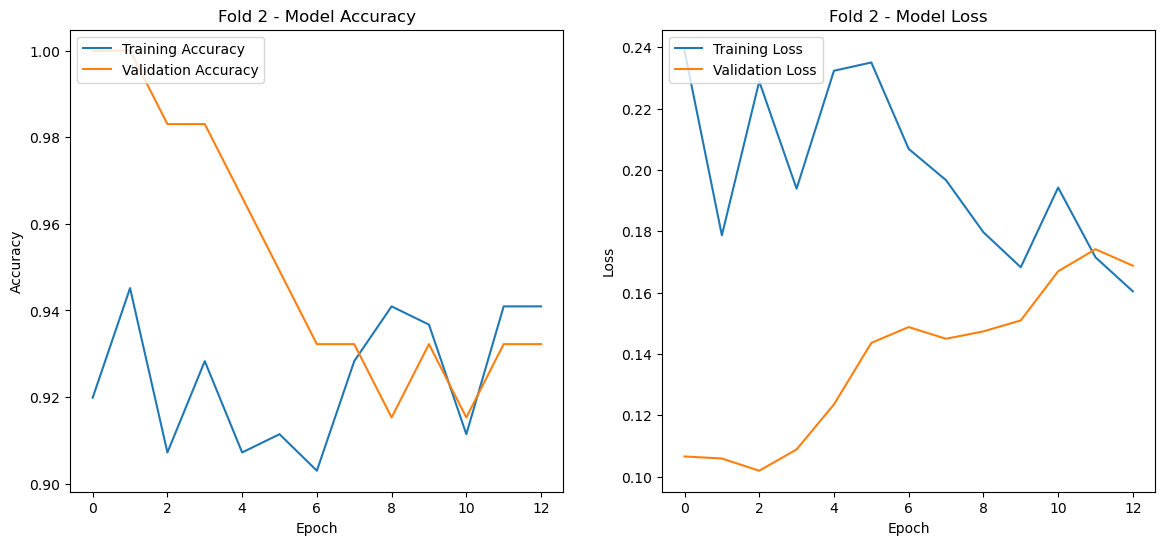

Fold 3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 3 results - Accuracy: 0.9661016949152542, Precision: 0.96875, Recall: 0.96875, F1 Score: 0.96875, ROC AUC: 0.9918981481481481


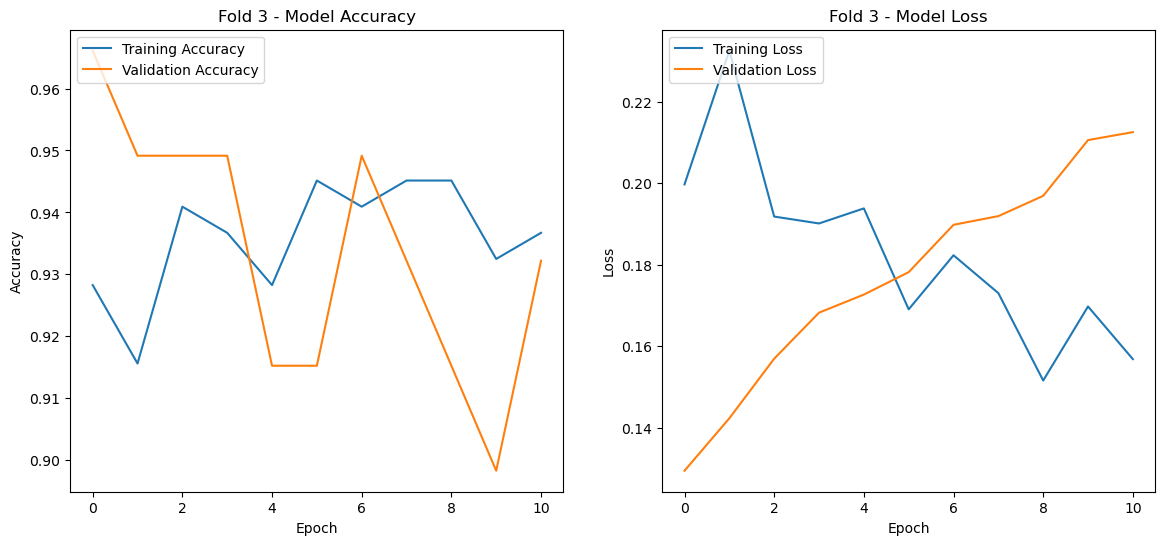

Fold 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 4 results - Accuracy: 0.9661016949152542, Precision: 0.96875, Recall: 0.96875, F1 Score: 0.96875, ROC AUC: 0.9872685185185185


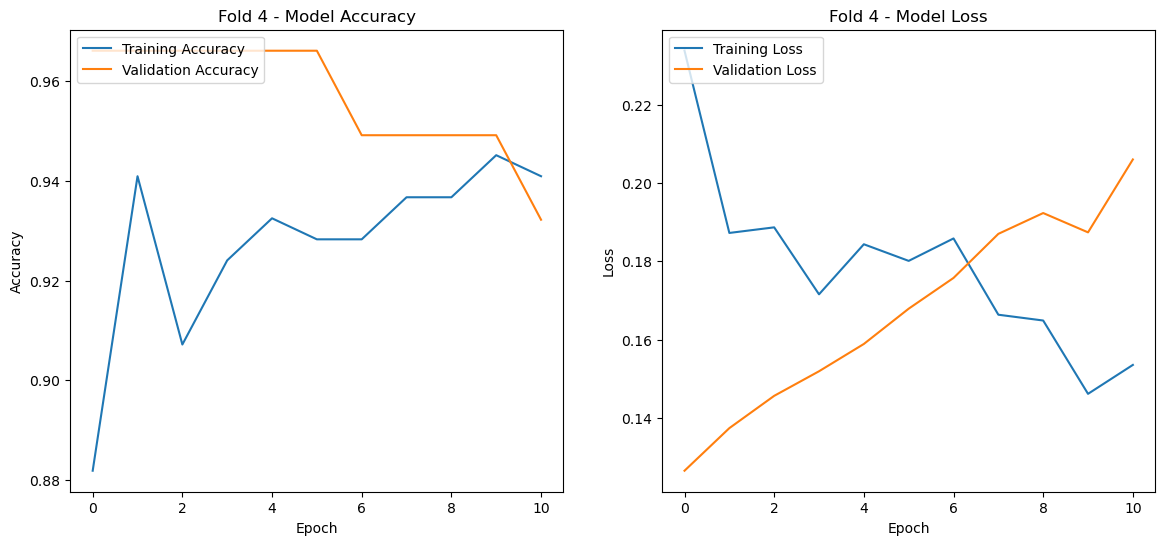

Fold 5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 5 results - Accuracy: 0.9661016949152542, Precision: 0.9411764705882353, Recall: 1.0, F1 Score: 0.9696969696969697, ROC AUC: 0.9872685185185185


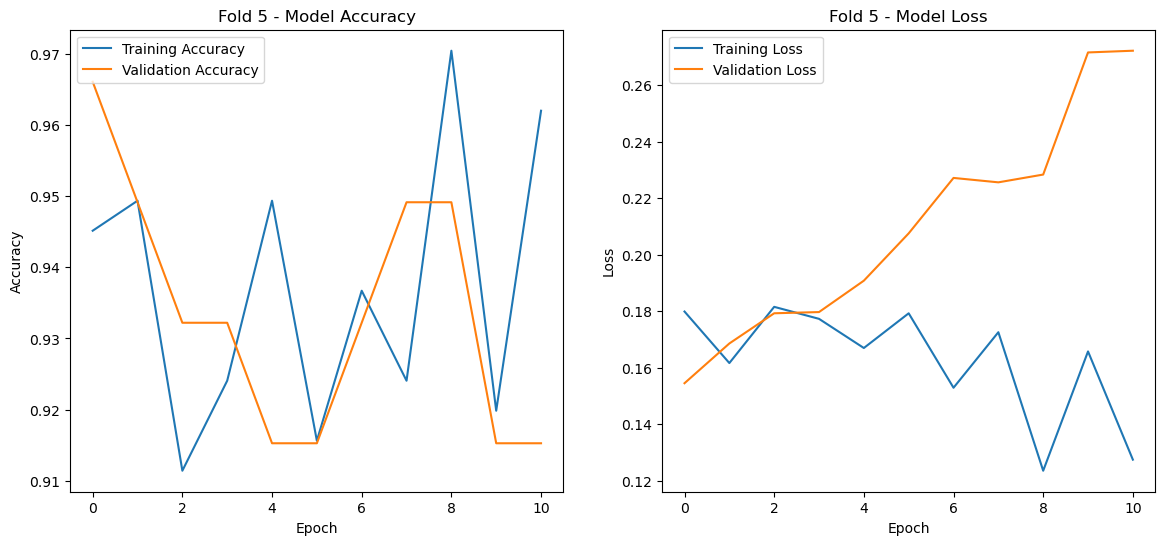

Mean Results - Accuracy: 0.9596045197740113, Precision: 0.9514928698752229, Recall: 0.975, F1 Score: 0.9629778554778555, ROC AUC: 0.9874834656084657


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the Stratified K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Track results
results = []
all_y_true = []
all_y_pred = []
all_y_pred_proba = []

for fold_no, (train_index, val_index) in enumerate(kfold.split(X, y), 1):
    print(f"Fold {fold_no}")
    
    # Split data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = best_model.fit(X_train, y_train, 
                             epochs=50, 
                             verbose=0, 
                             validation_data=(X_val, y_val), 
                             callbacks=[early_stopping])
    
    # Evaluate the model on the validation set
    y_pred_proba = best_model.predict(X_val).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Store results for later analysis
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)
    all_y_pred_proba.extend(y_pred_proba)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    print(f"Fold {fold_no} results - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, ROC AUC: {roc_auc}")
    
    results.append([accuracy, precision, recall, f1, roc_auc])

    # Plot the history of accuracy and loss for this fold
    plt.figure(figsize=(14, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold_no} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_no} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Calculate the mean results and log to metrics_df
mean_results = np.mean(results, axis=0)
print(f"Mean Results - Accuracy: {mean_results[0]}, Precision: {mean_results[1]}, Recall: {mean_results[2]}, F1 Score: {mean_results[3]}, ROC AUC: {mean_results[4]}")

# Append the mean results to the metrics DataFrame
metrics_df.loc[len(metrics_df)] = ['NeuralNetwork_Final', *mean_results]

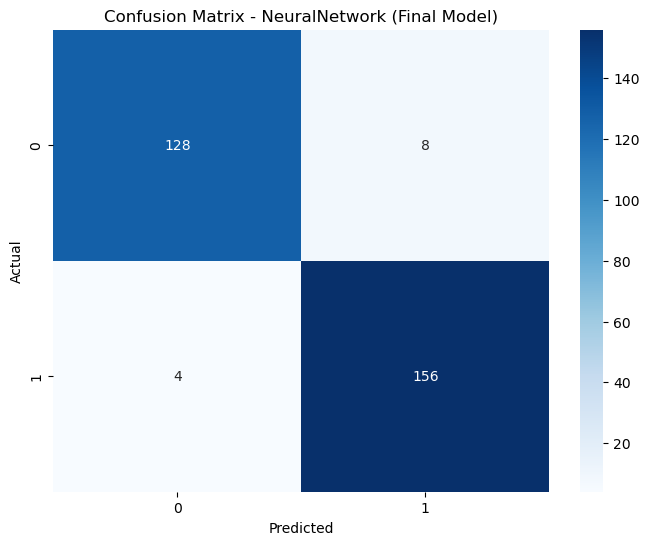

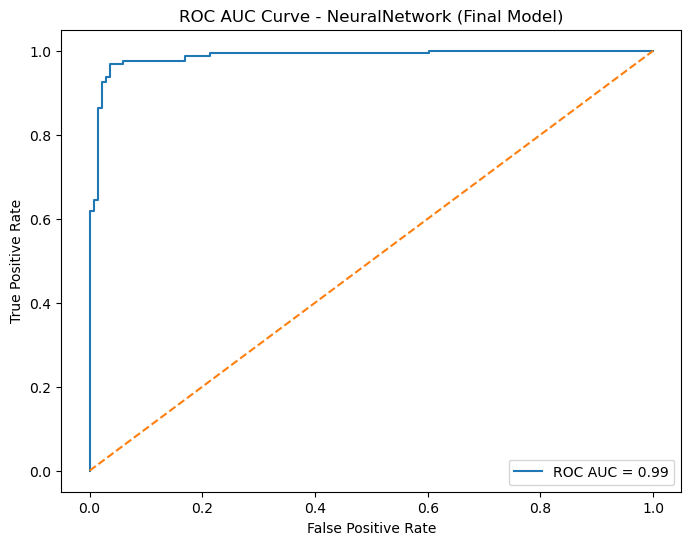

Final experiment completed.


In [23]:
# Plot confusion matrix for all predictions
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - NeuralNetwork (Final Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Results/confusion_matrix_NeuralNetwork_Final.png')
plt.show()

# Plot ROC AUC curve for all predictions
fpr, tpr, _ = roc_curve(all_y_true, all_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(all_y_true, all_y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC AUC Curve - NeuralNetwork (Final Model)')
plt.legend(loc='lower right')
plt.savefig('Results/roc_auc_NeuralNetwork_Final.png')
plt.show()

# Save the metrics DataFrame to a CSV file
metrics_df.to_csv('Results/metrics_NeuralNetwork_Final.csv', index=False)

print("Final experiment completed.")

In [24]:
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegression,0.854730,0.823204,0.93125,0.873900,0.909651
1,XGBClassifier,0.858108,0.839080,0.91250,0.874251,0.911811
2,SVC,0.864865,0.844828,0.91875,0.880240,0.910570
3,NeuralNetwork,0.895198,0.884533,0.93125,0.905947,0.965021
4,NeuralNetwork_Final,0.959605,0.951493,0.97500,0.962978,0.987483
